Batches: 100%|██████████| 331/331 [00:09<00:00, 34.01it/s]
/home/arko/VSC/IDS_705_Final_Project/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/arko/VSC/IDS_705_Final_Project/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


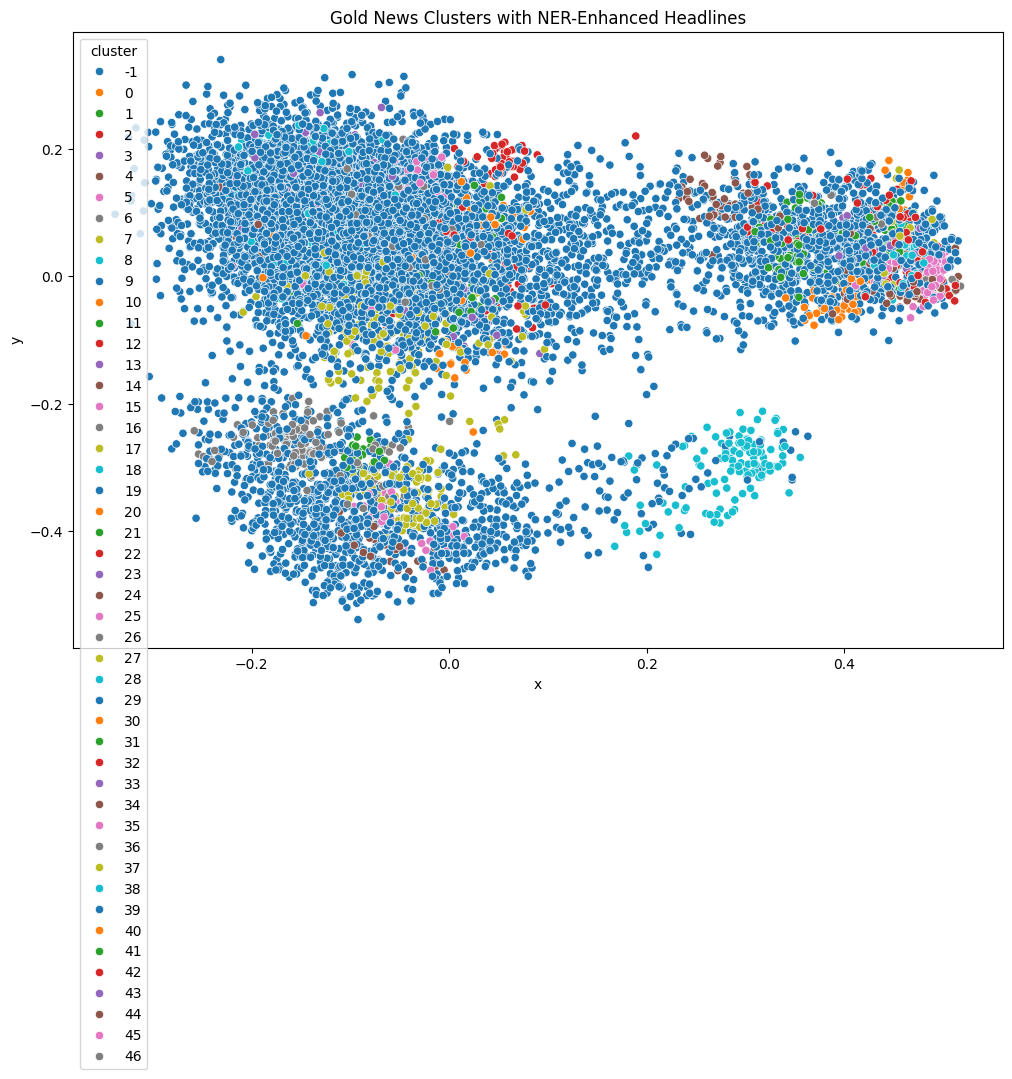

Cluster 0: amex, bugs, index, gold, ends
Cluster 1: cboe, index, closes, gold, close
Cluster 2: philadelphia, index, silver, gold, falls
Cluster 3: korea, north, tensions, high, hits
Cluster 4: kotak, commodity, mcx, support, rs
Cluster 5: achiievers, equities, range, trade, gold
Cluster 6: mcx, target, rs, sell, gold
Cluster 7: mcx, contract, goldguinea, goldpetal, goldm
Cluster 8: commodity, bets, copper, crude, tips
Cluster 9: tariff, value, import, govt, government
Cluster 10: claims, jobless, report, holds, reports
Cluster 11: copper, outlook, silver, weekly, futures
Cluster 12: quoted, spot, asia, trade, gold
Cluster 13: angel, commodities, trade, today, prices
Cluster 14: york, new, quoted, spot, gold
Cluster 15: fed, settles, ahead, meeting, minutes
Cluster 16: morning, silver, trade, today, rate
Cluster 17: rate, trends, price, check, today
Cluster 18: india, asia, prices, demand, fed
Cluster 19: cues, global, demand, weak, silver
Cluster 20: rs, kg, silver, falls, 31
Cluster 

In [10]:
import pandas as pd
import numpy as np
import spacy
from sentence_transformers import SentenceTransformer
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load data
gold_df = pd.read_csv("gold-dataset-sinha-khandait.csv")
headlines = gold_df["News"].dropna().astype(str).tolist()
gold_df = gold_df.loc[gold_df["News"].notna()].copy()

# Load spaCy model
nlp = spacy.load("en_core_web_sm")


# Extract filtered named entities
def extract_entities(text, allowed_types={"ORG", "GPE", "PERSON", "EVENT"}):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in allowed_types]


gold_df["entities"] = gold_df["News"].apply(lambda x: extract_entities(x))
gold_df["hybrid_text"] = gold_df.apply(
    lambda row: row["News"] + " " + " ".join(row["entities"]), axis=1
)
hybrid_texts = gold_df["hybrid_text"].tolist()

# Embed using Sentence-BERT
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(hybrid_texts, show_progress_bar=True)

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True)
clusters = clusterer.fit_predict(embeddings)
gold_df["cluster"] = clusters

# TF-IDF keyword extraction per cluster
tfidf = TfidfVectorizer(stop_words="english", max_features=1000)
X_tfidf = tfidf.fit_transform(gold_df["hybrid_text"])


def get_top_keywords(cluster_id, top_n=5):
    cluster_texts = gold_df[gold_df.cluster == cluster_id]["hybrid_text"]
    tfidf_cluster = tfidf.transform(cluster_texts)
    mean_tfidf = np.asarray(tfidf_cluster.mean(axis=0)).flatten()
    top_indices = mean_tfidf.argsort()[::-1][:top_n]
    return [tfidf.get_feature_names_out()[i] for i in top_indices]


theme_dict = {}
unique_clusters = sorted(gold_df["cluster"].unique())
for cid in unique_clusters:
    if cid == -1:
        continue
    theme_dict[cid] = get_top_keywords(cid)

# PCA for visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)
gold_df["x"] = reduced[:, 0]
gold_df["y"] = reduced[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=gold_df, x="x", y="y", hue="cluster", palette="tab10", legend="full"
)
plt.title("Gold News Clusters with NER-Enhanced Headlines")
plt.show()

# Print themes
for cid, keywords in theme_dict.items():
    print(f"Cluster {cid}: {', '.join(keywords)}")

[nltk_data] Downloading package stopwords to /home/arko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Batches: 100%|██████████| 331/331 [00:08<00:00, 39.72it/s]


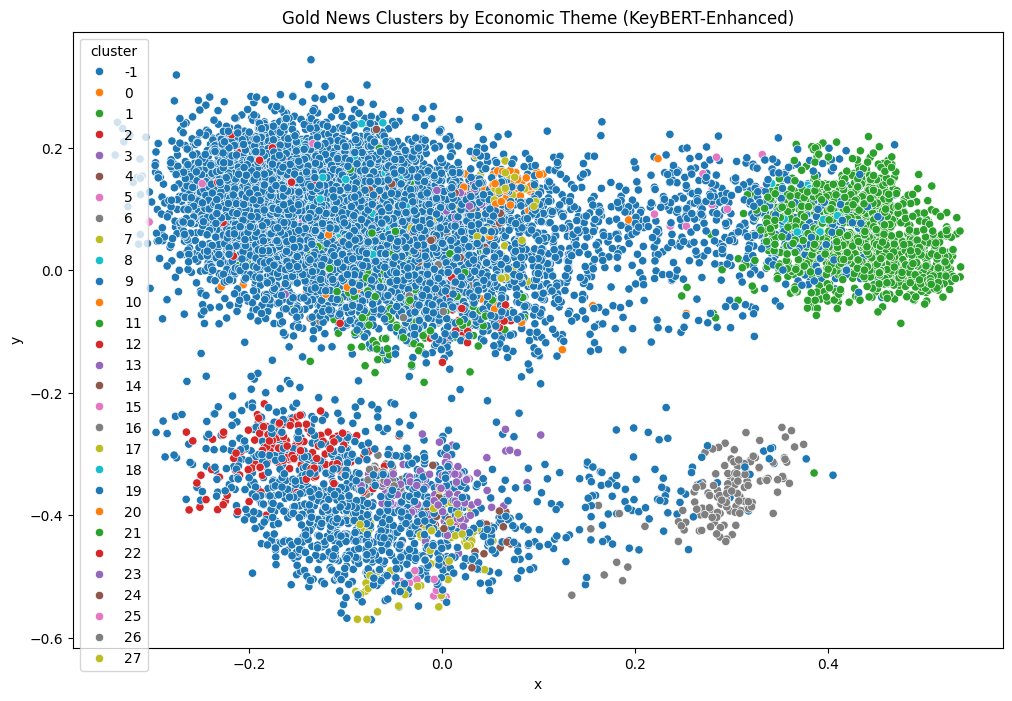


Top Themes per Cluster:
Cluster 0: bets, crude, copper, tips, commodity
Cluster 1: contract, mcx, goldguinea, goldpetal, trades
Cluster 2: amex, bugs, index, ends, closes
Cluster 3: achiievers, equities, range, trade, gold
Cluster 4: target, mcx, rs, sell, buy
Cluster 5: import, value, tariff, govt, duty
Cluster 6: cboe, index, closes, gold, close
Cluster 7: index, philadelphia, silver, falls, gold
Cluster 8: trade, angel, morning, today, commodities
Cluster 9: york, quoted, spot, new, gold
Cluster 10: quoted, spot, asia, trade, gold
Cluster 11: india, demand, wgc, tonnes, 2017
Cluster 12: asia, prices, demand, physical, gain
Cluster 13: metros, major, india, prices, rates
Cluster 14: prices, strengthens, remain, dollar, lower
Cluster 15: buy, dips, comex, oz, ounce
Cluster 16: outlook, copper, weekly, silver, futures
Cluster 17: rs, kg, falls, silver, 31
Cluster 18: bid, spot, ounce, kitco, 10
Cluster 19: global, cues, demand, weak, rs
Cluster 20: settles, week, high, level, lowest
C

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from keybert import KeyBERT
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import nltk

nltk.download("stopwords")
from nltk.corpus import stopwords

# Load your dataset
gold_df = pd.read_csv("gold-dataset-sinha-khandait.csv")
gold_df = gold_df.loc[gold_df["News"].notna()].copy()
gold_df["News"] = gold_df["News"].astype(str)

# Step 1: Extract data-driven economic themes using KeyBERT
kw_model = KeyBERT(model="all-MiniLM-L6-v2")


def extract_keybert_themes(text):
    keywords = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 3),
        stop_words="english",
        use_maxsum=True,
        top_n=5,
    )
    return [kw for kw, score in keywords]


gold_df["econ_themes"] = gold_df["News"].apply(extract_keybert_themes)

# Step 2: Create hybrid text (original + key phrases)
gold_df["hybrid_text"] = gold_df.apply(
    lambda row: row["News"] + " " + " ".join(row["econ_themes"]), axis=1
)

# Step 3: Embed with Sentence-BERT
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(gold_df["hybrid_text"].tolist(), show_progress_bar=True)

# Step 4: Cluster with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True)
clusters = clusterer.fit_predict(embeddings)
gold_df["cluster"] = clusters

# Step 5: Extract top TF-IDF keywords per cluster
tfidf = TfidfVectorizer(stop_words="english", max_features=1000)
X_tfidf = tfidf.fit_transform(gold_df["hybrid_text"])


def get_top_keywords(cluster_id, top_n=5):
    cluster_texts = gold_df[gold_df.cluster == cluster_id]["hybrid_text"]
    tfidf_cluster = tfidf.transform(cluster_texts)
    mean_tfidf = np.asarray(tfidf_cluster.mean(axis=0)).flatten()
    top_indices = mean_tfidf.argsort()[::-1][:top_n]
    return [tfidf.get_feature_names_out()[i] for i in top_indices]


theme_dict = {}
unique_clusters = sorted(gold_df["cluster"].unique())
for cid in unique_clusters:
    if cid == -1:
        continue
    theme_dict[cid] = get_top_keywords(cid)

# Step 6: Visualize with PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)
gold_df["x"] = reduced[:, 0]
gold_df["y"] = reduced[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=gold_df, x="x", y="y", hue="cluster", palette="tab10", legend="full"
)
plt.title("Gold News Clusters by Economic Theme (KeyBERT-Enhanced)")
plt.show()

# Step 7: Print cluster themes
print("\nTop Themes per Cluster:")
for cid, keywords in theme_dict.items():
    print(f"Cluster {cid}: {', '.join(keywords)}")

# Optional: save to CSV
gold_df.to_csv("gold_news_clustered.csv", index=False)